In [1]:
import json

import matplotlib.pyplot as plt
import numpy as np
from paprika.analysis.bootstrap import integrate_bootstraps
from paprika.analysis.utils import get_block_sem, get_nearest_max
from paprika.io import PaprikaEncoder
from tqdm.notebook import tqdm

# Input Options

In [2]:
lambda_values = np.linspace(0, 1, 11)
boot_cycles = 2000
fractions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

work_folder = "simulations"
fepout_file = "production.fepout"
n_lambda = len(lambda_values)
ti_folders = [f"t{i:03}" for i in range(len(lambda_values))]

# Extract $\frac{dU}{d\lambda}$ from each window

In [3]:
def read_ti_file(ti_file, extract_average=False):
    ii = 0
    if extract_average:
        ii = 1

    elec_1 = []
    elec_2 = []
    vdw_1 = []
    vdw_2 = []

    with open(ti_file, "r") as f:
        for line in f.readlines():
            if line.startswith("#"):
                continue

            dummy = line.split()

            elec_1.append(float(dummy[4 + ii]))
            vdw_1.append(float(dummy[6 + ii]))

            elec_2.append(float(dummy[10 + ii]))
            vdw_2.append(float(dummy[12 + ii]))

    elec_1 = np.array(elec_1)
    elec_2 = np.array(elec_2)
    vdw_1 = np.array(vdw_1)
    vdw_2 = np.array(vdw_2)

    return elec_1, vdw_1, elec_2, vdw_2

In [4]:
dU_dl = []

for i, ti in enumerate(ti_folders):
    ti_file = f"{work_folder}/{ti}/{fepout_file}"
    elec_1, vdw_1, elec_2, vdw_2 = read_ti_file(ti_file)
    dU_dl.append((elec_1 - elec_2) + (vdw_1 - vdw_2))

dU_dl = np.array(dU_dl)

Text(0.5, 1.0, 'Raw TI data')

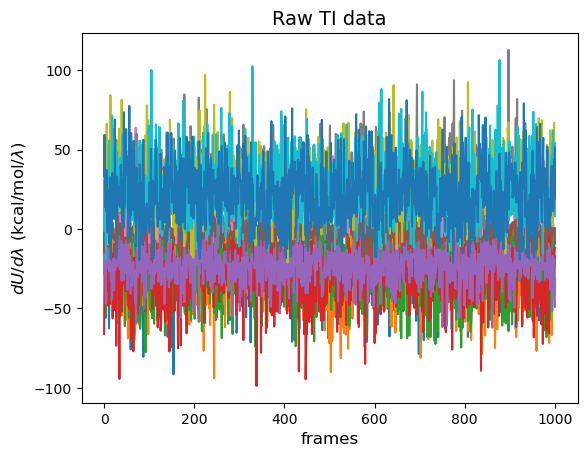

In [5]:
plt.figure(dpi=100)
for i in range(len(lambda_values)):
    plt.plot(dU_dl[i, :])

plt.xlabel("frames", fontsize=12)
plt.ylabel(r"$dU/d\lambda$ (kcal/mol/$\lambda$)", fontsize=12)
plt.title("Raw TI data", fontsize=14)

# Calculate Free Energy

In [6]:
dl_intp = np.zeros([0], np.float64)
for k in range(n_lambda):
    if k > 0:
        dl_intp = np.append(
            dl_intp,
            np.linspace(
                lambda_values[k - 1], lambda_values[k], num=100, endpoint=False
            ),
        )
dl_intp = np.append(dl_intp, lambda_values[-1])

In [7]:
results = {
    "fraction_n_frames": {},
    "fraction_fe_matrix": {},
    "fraction_sem_matrix": {},
    "fraction_fe": {},
    "fraction_sem": {},
    "n_frames": None,
    "fe": None,
    "sem": None,
    "fe_matrix": None,
    "sem_matrix": None,
}

n_frames = dU_dl.shape[1]

for fraction in tqdm(fractions):
    dU_avgs = np.mean(dU_dl[:, 0 : int(fraction * n_frames)], axis=-1)
    dU_sems = np.zeros(n_lambda)

    nearest_max = get_nearest_max(int(fraction * n_frames))
    for k in range(n_lambda):
        dU_sems[k] = get_block_sem(dU_dl[k, 0:nearest_max])

    dU_samples = np.random.normal(dU_avgs, dU_sems, size=(boot_cycles, n_lambda))

    (
        results["fraction_fe_matrix"][fraction],
        results["fraction_sem_matrix"][fraction],
    ) = integrate_bootstraps(lambda_values, dU_samples, x_intp=dl_intp, matrix="full")
    results["fraction_fe"][fraction] = results["fraction_fe_matrix"][fraction][0, -1]
    results["fraction_sem"][fraction] = results["fraction_sem_matrix"][fraction][0, -1]

    results["fraction_n_frames"][fraction] = int(fraction * n_frames) * n_lambda

max_fraction = np.max(fractions)
results["fe_matrix"] = results["fraction_fe_matrix"][max_fraction]
results["sem_matrix"] = results["fraction_sem_matrix"][max_fraction]

results["fe"] = results["fe_matrix"][0, -1]
results["sem"] = results["sem_matrix"][0, -1]

results["n_frames"] = n_frames * n_lambda

  0%|          | 0/10 [00:00<?, ?it/s]

In [8]:
print(f"Delta G(A->B) = {results['fe']:.2f} +- {results['sem']:.2f} kcal/mol")

Delta G(A->B) = -0.21 +- 0.27 kcal/mol


# Plot Free Energy profile

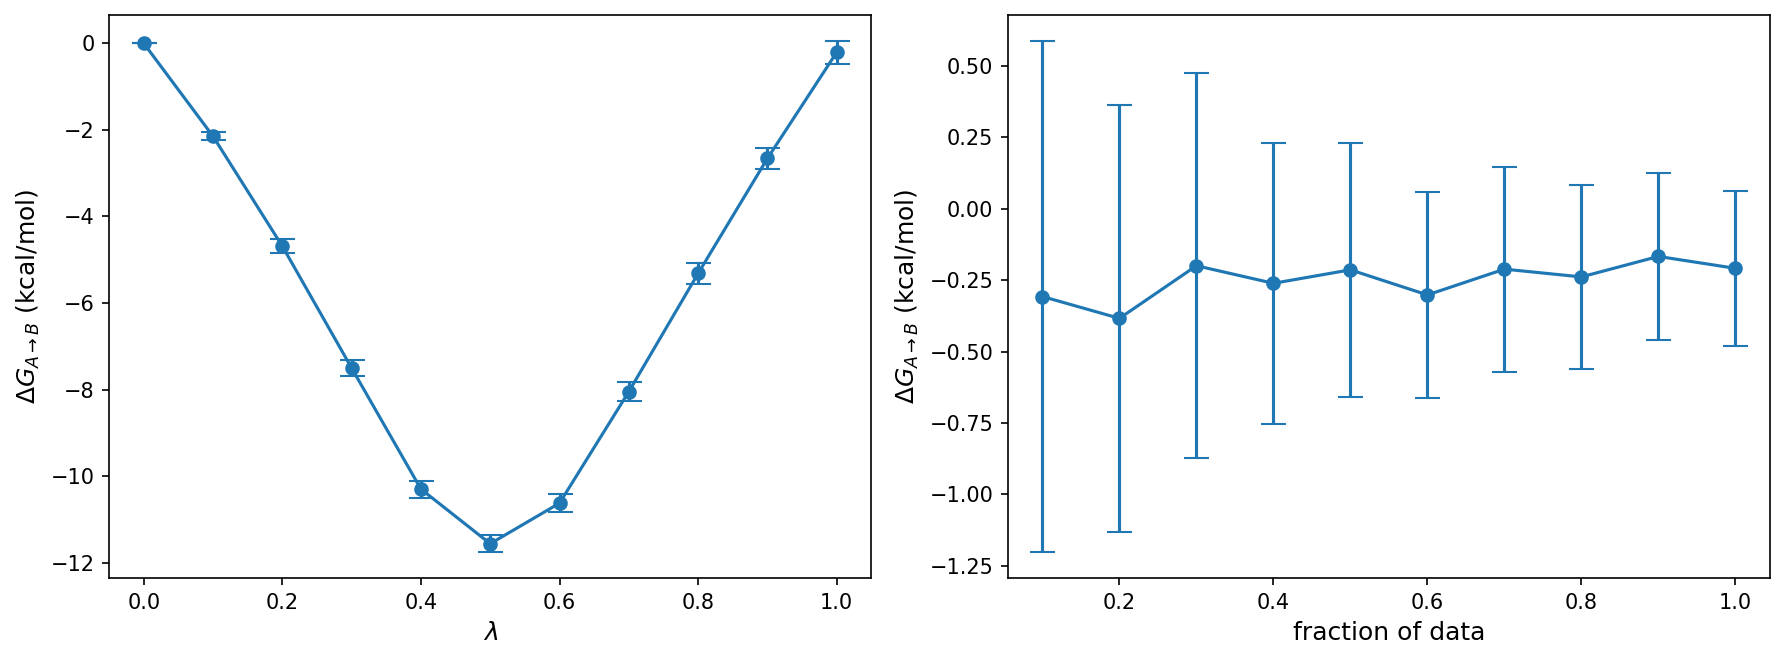

In [9]:
plt.figure(dpi=150, figsize=(12, 4.5))

plt.subplot(1, 2, 1)
plt.errorbar(
    lambda_values,
    results["fe_matrix"][0, :],
    yerr=results["sem_matrix"][0, :],
    fmt="-o",
    capsize=6,
)
plt.xlabel(r"$\lambda$", fontsize=12)
plt.ylabel(r"$\Delta G_{A\rightarrow B}$ (kcal/mol)", fontsize=12)
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.errorbar(
    fractions,
    [results["fraction_fe"][i] for i in results["fraction_fe"]],
    yerr=[results["fraction_sem"][i] for i in results["fraction_sem"]],
    fmt="-o",
    capsize=6,
)
plt.xlabel(r"fraction of data", fontsize=12)
plt.ylabel(r"$\Delta G_{A\rightarrow B}$ (kcal/mol)", fontsize=12)
plt.tight_layout()

# Save Results to file

In [10]:
with open("ti_results.json", "w") as f:
    dumped = json.dumps(results, cls=PaprikaEncoder)
    f.write(dumped)

In [11]:
with open("ti-fe.csv", "w") as f:
    f.writelines("#lambda, FE, Error\n")
    for i in range(n_lambda):
        f.writelines(
            "%.5f,%.4f,%.4f\n"
            % (
                lambda_values[i],
                results["fe_matrix"][0, i],
                results["sem_matrix"][0, i],
            )
        )